# AlexNet

In [1]:
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn
import numpy as np
from torchsummary import summary
from tqdm import tqdm

In [2]:
# 3.1 ReLU Nonlinearity

def ReLU(x):
    x = max(0, x)
    return x

#기존 LeNet의 tanh를 사용하지 않고 ReLU활성 함수를 사용하여 빠르게 수렴하는 결과를 얻었다.

In [3]:
# 3.3 Local Response Normalization
# 논문에 따르면, 다양한 값들을 validation(검증)한 후 alpha, beta, k, size값을 정하였다. 약 1.3%의 Error rate를 줄일 수 있었다.

class LocalResponseNorm(nn.Module):
    def __init__(self, size, k=2.0, alpha=1e-4, beta=0.75):
        super(LocalResponseNorm, self).__init__()
        self.size = size
        self.k = k
        self.alpha = alpha
        self.beta = beta

    def forward(self, x):
        _, C, _, _ = x.size()
        half_size = self.size // 2
        square_sum = torch.zeros_like(x)
        
        for i in range(C):
            left = max(0, i - half_size)
            right = min(C, i + half_size)
            square_sum[:, i, :, :] = torch.sum(x[:, left:right, :, :] ** 2, dim=1)
        scale = self.k + self.alpha * square_sum
        scale = scale ** self.beta
        x = x / scale
        return x

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        
        # 첫 번째 합성곱 계층: 96개의 11x11 필터, 스트라이드 4
        self.c1a = nn.Conv2d(3, 48, kernel_size=11, stride=4)  # (224, 224, 3) -> (55, 55, 48)
        self.c1b = nn.Conv2d(3, 48, kernel_size=11, stride=4)  # (224, 224, 3) -> (55, 55, 48)
        self.norm1a = LocalResponseNorm(5)
        self.norm1b = LocalResponseNorm(5)
        self.p1a = nn.MaxPool2d(kernel_size=3, stride=2)  # (55, 55, 48) -> (27, 27, 48)
        self.p1b = nn.MaxPool2d(kernel_size=3, stride=2)  # (55, 55, 48) -> (27, 27, 48)
        
        # 두 번째 합성곱 계층: 256개의 5x5 필터, 패딩 2
        self.c2a = nn.Conv2d(48, 128, kernel_size=5, padding=2)  # (27, 27, 48) -> (27, 27, 128)
        self.c2b = nn.Conv2d(48, 128, kernel_size=5, padding=2)  # (27, 27, 48) -> (27, 27, 128)
        self.norm2a = LocalResponseNorm(5)
        self.norm2b = LocalResponseNorm(5)
        self.p2a = nn.MaxPool2d(kernel_size=3, stride=2)  # (27, 27, 128) -> (13, 13, 128)
        self.p2b = nn.MaxPool2d(kernel_size=3, stride=2)  # (27, 27, 128) -> (13, 13, 128)
        
        # 세 번째 합성곱 계층: 384개의 3x3 필터, 패딩 1
        self.c3a = nn.Conv2d(256, 192, kernel_size=3, padding=1)  # (13, 13, 128) -> (13, 13, 192)
        self.c3b = nn.Conv2d(256, 192, kernel_size=3, padding=1)  # (13, 13, 128) -> (13, 13, 192)
        
        # 네 번째 합성곱 계층: 384개의 3x3 필터, 패딩 1
        self.c4a = nn.Conv2d(192, 192, kernel_size=3, padding=1)  # (13, 13, 384) -> (13, 13, 384)
        self.c4b = nn.Conv2d(192, 192, kernel_size=3, padding=1)  # (13, 13, 384) -> (13, 13, 384)

        # 다섯 번째 합성곱 계층: 256개의 3x3 필터, 패딩 1
        self.c5a = nn.Conv2d(192, 128, kernel_size=3, padding=1)  # (13, 13, 192) -> (13, 13, 128)
        self.c5b = nn.Conv2d(192, 128, kernel_size=3, padding=1)  # (13, 13, 192) -> (13, 13, 128)
        self.p3a = nn.MaxPool2d(kernel_size=3, stride=2)  # (13, 13, 128) -> (5, 5, 128)
        self.p3b = nn.MaxPool2d(kernel_size=3, stride=2)  # (13, 13, 128) -> (5, 5, 128)
        
        # 완전 연결 계층: 4096 뉴런
        self.fc1a = nn.Linear(6400, 2048)
        self.fc1b = nn.Linear(6400, 2048)
        self.fc2a = nn.Linear(4096, 2048)
        self.fc2b = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(4096, 1000)  # 1000 클래스
        
    def forward(self, x):
        # 첫 번째 병렬 계산
        x1 = F.relu(self.c1a(x))
        x2 = F.relu(self.c1b(x))
        x1 = self.norm1a(x1)
        x2 = self.norm1b(x2)
        x1 = self.p1a(x1)
        x2 = self.p1b(x2)
        
        # 두 번째 병렬 계산
        x1 = F.relu(self.c2a(x1))
        x2 = F.relu(self.c2b(x2))
        x1 = self.norm2a(x1)
        x2 = self.norm2b(x2)
        x1 = self.p2a(x1)
        x2 = self.p2b(x2)
        x = torch.cat((x1, x2), 1)
        x1 = F.relu(self.c3a(x))
        x2 = F.relu(self.c3b(x))
        
        # 세 번째 합성곱 계층에서 네 번째 합성곱 계층으로 갈 때 합침
        x1 = F.relu(self.c4a(x1))
        x2 = F.relu(self.c4b(x2))
        
        x1 = F.relu(self.c5a(x1))
        x2 = F.relu(self.c5b(x2))
        x1 = self.p3a(x1)
        x2 = self.p3b(x2)
        
        # 완전 연결 계층으로 갈 때 합침
        x1 = torch.flatten(x1, 1)
        x2 = torch.flatten(x2, 1)
        x = torch.cat((x1, x2), 1)


        # 완전 연결 계층 병렬 계산
        x1 = F.relu(self.fc1a(x))
        x2 = F.relu(self.fc1b(x))
        x = torch.cat((x1, x2), 1)


        x = F.dropout(x, 0.5)
        x1 = F.relu(self.fc2a(x))
        x2 = F.relu(self.fc2b(x))
        x = torch.cat((x1, x2), 1)
        
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

# Example instantiation of the model
model = AlexNet()
# 모델을 CUDA로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)

In [6]:
# Summary of the model
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 54, 54]          17,472
            Conv2d-2           [-1, 48, 54, 54]          17,472
 LocalResponseNorm-3           [-1, 48, 54, 54]               0
 LocalResponseNorm-4           [-1, 48, 54, 54]               0
         MaxPool2d-5           [-1, 48, 26, 26]               0
         MaxPool2d-6           [-1, 48, 26, 26]               0
            Conv2d-7          [-1, 128, 26, 26]         153,728
            Conv2d-8          [-1, 128, 26, 26]         153,728
 LocalResponseNorm-9          [-1, 128, 26, 26]               0
LocalResponseNorm-10          [-1, 128, 26, 26]               0
        MaxPool2d-11          [-1, 128, 12, 12]               0
        MaxPool2d-12          [-1, 128, 12, 12]               0
           Conv2d-13          [-1, 192, 12, 12]         442,560
           Conv2d-14          [-1, 192,

In [5]:
# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# 데이터셋 및 데이터 로더 설정
train_dataset = datasets.ImageFolder(root='E:\\puzzle\\data\\ImageNet10\\train', transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_dataset = datasets.ImageFolder(root='E:\\puzzle\\data\\ImageNet10\\val', transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [8]:
# Model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
for epoch in range(10):  # Number of epochs can be adjusted
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")
    
# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy}")

print("Finished Training")

Training Epoch 1: 100%|██████████| 325/325 [01:25<00:00,  3.80it/s]


Epoch 1, Loss: 3.3312854744837836


Training Epoch 2: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]


Epoch 2, Loss: 2.290846290221581


Training Epoch 3: 100%|██████████| 325/325 [01:24<00:00,  3.86it/s]


Epoch 3, Loss: 1.9443548367573664


Training Epoch 4: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]


Epoch 4, Loss: 1.7615568630511944


Training Epoch 5: 100%|██████████| 325/325 [01:22<00:00,  3.93it/s]


Epoch 5, Loss: 1.593963459088252


Training Epoch 6: 100%|██████████| 325/325 [01:22<00:00,  3.93it/s]


Epoch 6, Loss: 1.4917894202012283


Training Epoch 7: 100%|██████████| 325/325 [01:23<00:00,  3.90it/s]


Epoch 7, Loss: 1.3743375956095183


Training Epoch 8: 100%|██████████| 325/325 [01:21<00:00,  4.00it/s]


Epoch 8, Loss: 1.2874987310629624


Training Epoch 9: 100%|██████████| 325/325 [01:22<00:00,  3.93it/s]


Epoch 9, Loss: 1.2393454436155467


Training Epoch 10: 100%|██████████| 325/325 [01:26<00:00,  3.74it/s]


Epoch 10, Loss: 1.162907821398515


Validation Epoch 10: 100%|██████████| 82/82 [00:13<00:00,  6.10it/s]

Validation Accuracy: 0.6823076923076923
Finished Training


In [89]:
torch.save(model.state_dict(), './AlexNet_Epoch10.pth')

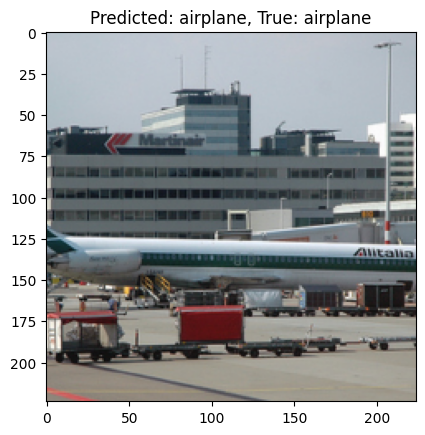

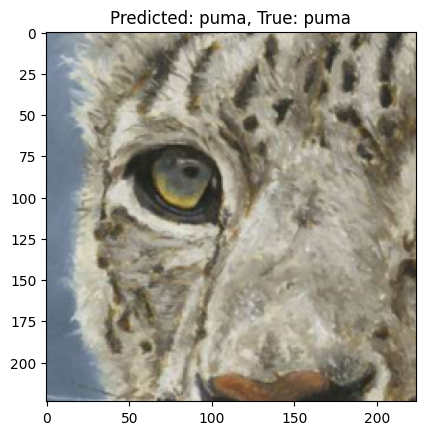

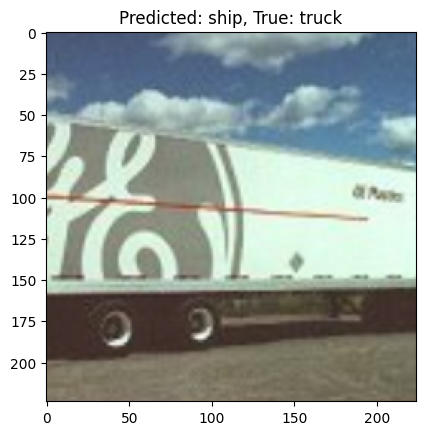

In [101]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def unnormalize(x):
    mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
    std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
    x = x * std + mean
    return x

class_names = train_dataset.classes

model = AlexNet()
model.load_state_dict(torch.load('AlexNet_Epoch10.pth'))
model.eval()

def predict_and_show_image(model, image, label):
    image = image.unsqueeze(0)
    with torch.no_grad():
        output = model(image)
        pred = output.argmax(dim=1)
    image = unnormalize(image.squeeze())
    plt.imshow(to_pil_image(image))
    plt.title(f'Predicted: {class_names[pred.item()]}, True: {class_names[label]}')
    plt.show()

# Assuming you have a DataLoader called `val_dataset`
test_loader = DataLoader(val_dataset, batch_size=3, shuffle=True)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# Show and predict for the first 3 images
for i in range(3):
    predict_and_show_image(model, example_data[i], example_targets[i].item())

In [6]:

class AugmentedDataset(Dataset):
    def __init__(self, root, transform=None, augment_transform=None):
        self.dataset = datasets.ImageFolder(root=root)
        self.transform = transform
        self.augment_transform = augment_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]
        img = self.transform(img) if self.transform else img
        img_aug = self.augment_transform(img) if self.augment_transform else img
        return img, img_aug, label

def add_pca_jitter(image):
    """이미지에 PCA 기반 색 변화를 추가하는 함수."""
    # 이미지 텐서를 numpy 배열로 변환
    img = image.numpy()
    img = img.transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    
    # PCA 적용을 위한 RGB 픽셀 값의 공분산 행렬 계산
    img_flat = img.reshape(-1, 3)
    img_mean = np.mean(img_flat, axis=0)
    img_centered = img_flat - img_mean
    cov_matrix = np.cov(img_centered, rowvar=False)
    
    # 고유값과 고유벡터 계산
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    
    # 색 변화 추가
    alpha = np.random.normal(0, 0.1, size=(3,))
    jitter = eigvecs @ (alpha * eigvals)
    
    img_jittered = img + jitter
    img_jittered = np.clip(img_jittered, 0, 1)
    img_jittered = img_jittered.transpose(2, 0, 1)  # (H, W, C) -> (C, H, W)
    
    return torch.tensor(img_jittered, dtype=torch.float32)

# 데이터 증강 설정
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  # 224x224 크기의 패치로 무작위로 잘라냅니다.
    transforms.RandomHorizontalFlip(),  # 무작위로 수평 반사를 적용합니다.
    transforms.ToTensor(),  # 이미지를 텐서로 변환합니다.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 이미지 정규화
])

augment_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(add_pca_jitter)
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
# 학습 데이터셋 로드
train_dataset = AugmentedDataset(root='E:\\puzzle\\data\\ImageNet10\\train', transform=transform_train, augment_transform=augment_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

In [8]:
# Model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
for epoch in range(10):  # Number of epochs can be adjusted
    model.train()
    running_loss = 0.0
    for images, aug_images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images, aug_images, labels = images.to(device), aug_images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        outputs_aug = model(aug_images)
        loss_aug = criterion(outputs_aug, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += (loss.item() * inputs.size(0) + loss_aug.item() * inputs.size(0))
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")
    
# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy}")

print("Finished Training")

Training Epoch 1:   0%|          | 0/82 [00:00<?, ?it/s]

In [ ]:
# Show and predict for the first 3 images
for i in range(3):
    predict_and_show_image(model, example_data[i], example_targets[i].item())